# Filtro de partículas


Cada partícula vai ser representada por uma lista [x,y,theta]

Trabalhe com 2 listas:

	S = []  # Vai conter as n partículas. 

	W = [] # Pesos das partículas

	n_part = # Número de partículas


# Atividades


1. Crie uma função que gere n partículas aleatórias distribuidas uniformemente dentro de uma área minx, miny, maxx, maxy (passados como parâmetros). Veja a funcao 

	Devolve uma lista com n partículas

2. Descubra como desenhar as n partículas (analise o módulo inspercles)

3. Faça o desenho das partículas

4. Crie uma lista para simular os movimentos do robô. Veja a lista chamada <code>movimentos</code> que é usada na seção *Teste de animação*, mais abaixo

5. Crie uma função que aplica um deslocamento [delta_x, delta_y, delta_theta] com um desvio padrão [std_x, std_y, std_theta] a todas as partículas

6. Desenhe as partículas após o deslocamento

7. Descubra como calcular $P(D|H)$ analisando o Python Notebook. A função que traça os raios está no modulo inspercles

Programe a aplicação da equação que está na pág. 853 do livro do Norvig $$P(z_t | x_t) = \alpha \prod_{j}^M{e^{\frac{-(z_j - \hat{z_j})}{2\sigma^2}}}$$

Ou seja, para cada raio estimado $\hat{z_j}$ e leitura real $z_j$ calcule a probabilidade daquele raio ter acontecido dado que a posição do robô fosse de fato a da partícula


8 . Usando os resultados de 7 calcule $P(H|D)$ e insira numa lista de probabilidades das partículas

9 . Reamostre as partículas de forma proporcional à probabilidade



In [1]:
from random import randint, choice
import time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import math
import random
from pf import Particle
from nav_msgs.msg import OccupancyGrid
from occupancy_field import OccupancyField
from helper_functions import angle_normalize, angle_diff


import sys
import os
os.getcwd() 
import sys
sys.path.append(os.getcwd())


import inspercles
reload(inspercles)


# Para suprimir alguns warnings do Matplotlib Inline
import warnings
warnings.simplefilter('ignore')
%matplotlib inline


## Diretõrio de trabalho

In [2]:
!pwd




/home/borg/catkin_ws/src/robot17/particle_filter/jupyter_particle


In [3]:
# Dados do arquivo mapa.yaml

resolution = 0.020000
origin =  [-5.000000, -5.000000, 0.000000]
occupied_thresh = 0.2
free_thresh =  0.8

inspercles.free_thresh = free_thresh # Limiar em tons de cinza para que uma celula seja considerada livre
inspercles.occupied_thresh = occupied_thresh # Limiar de celula ocupada
inspercles.origin = origin
inspercles.resolution = resolution


In [4]:


from PIL import Image as PilImage
color_image = PilImage.open("sparse_obstacles.png", 'r')
pil_image = color_image.convert('1') # Converte a imagem PIL para Grayscale
np_image = np.asarray(pil_image)

particle_size = 10

#import matplotlib_render as plotmap


back_color = "black"
colors     = ['red', 'green', 'cyan', 'yellow']
width, height = 775, 746

inspercles.width = width
inspercles.height = height




initial_pose = [200, 200, math.pi/8] # Posicao inicial considerada para o pf
inspercles.initial_pose = initial_pose
pose = [330, 220, math.radians(90)] # posicao "verdadeira" do robo 
inspercles.pose = pose
robot_radius=10   # Raio do robo
inspercles.robot_radius = robot_radius


# Os angulos em que o robo simulado vai ter sensores
angles = np.linspace(0.0, 2*math.pi, num=8)

particle_cloud = []



    
    
    
    

## Mapa com posição inicial

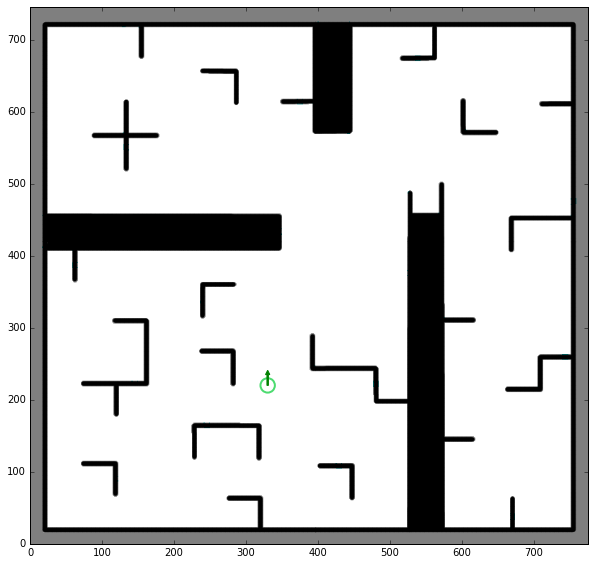

In [5]:
inspercles.nb_draw_map(color_image, pose=pose, robot=True)

A função *nb_initialize_particle_cloud()* pertence ao módulo <code>inspercles</code> e já faz uma primeira aleatorização das partículas

In [6]:
# Inicializa as particulas
particulas = inspercles.nb_initialize_particle_cloud()

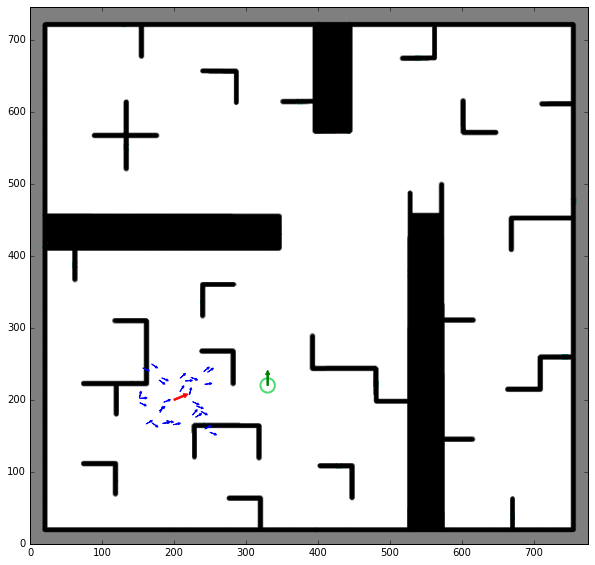

In [7]:
inspercles.nb_draw_map(color_image, particles = particulas, initial_position = initial_pose, pose=pose, robot=True)

In [8]:
angles

array([ 0.        ,  0.8975979 ,  1.7951958 ,  2.6927937 ,  3.5903916 ,
        4.48798951,  5.38558741,  6.28318531])

# Simulação da imagem do laser

Para simular a leitura **real** do robo, use *nb_simulate_lidar* passando a posição real do robô, os ângulos do sensor e a np_image com o mapa

In [9]:
leituras, lidar_map = inspercles.nb_simulate_lidar(pose, angles, np_image)


('Outside at ', -1.1838159734534308, '  ', 484.1102800673617, '  for angle ', 2.4683942278205517)
('Outside at ', -1.0855189769466, '  ', 144.43189082843605, '  for angle ', 3.3659921288462069)
('Outside at ', 223.52493042054573, '  ', -1.097760183251609, '  for angle ', 4.2635900298718621)
('Outside at ', 436.47506957945427, '  ', -1.097760183251609, '  for angle ', 5.1611879308975173)


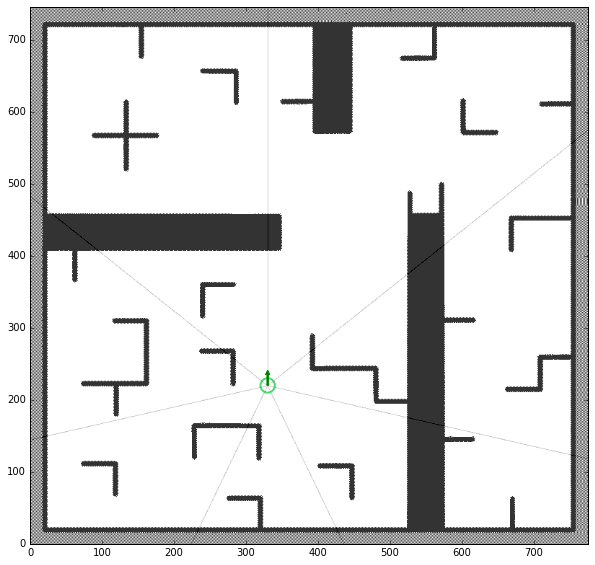

In [10]:
ax = inspercles.nb_draw_map(lidar_map, robot=True, pose=pose)
ax.imshow(pil_image, alpha=0.8)
#nb_draw_map(occupancy_image)

As leituras serao retornadas pela simulacao do lidar. Sao armazenadas na forma de um dicionario com angulo: valor da leitura

In [11]:
# As predicoes teoricas das leituras
leituras

{2.4683942278205517: -1,
 3.3659921288462069: -1,
 4.2635900298718621: -1,
 5.1611879308975173: -1}

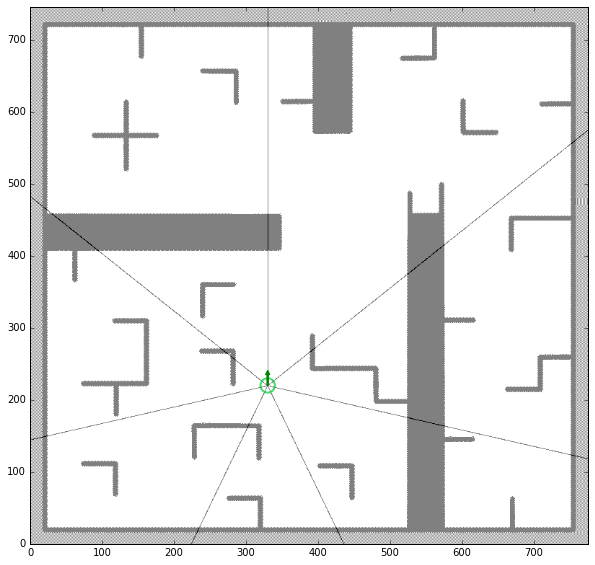

In [12]:
ax = inspercles.nb_draw_map(lidar_map, pose=pose, robot=True)
#ax.imshow(occupancy_image, alpha=0.2)
ax.imshow(pil_image, alpha=0.5)

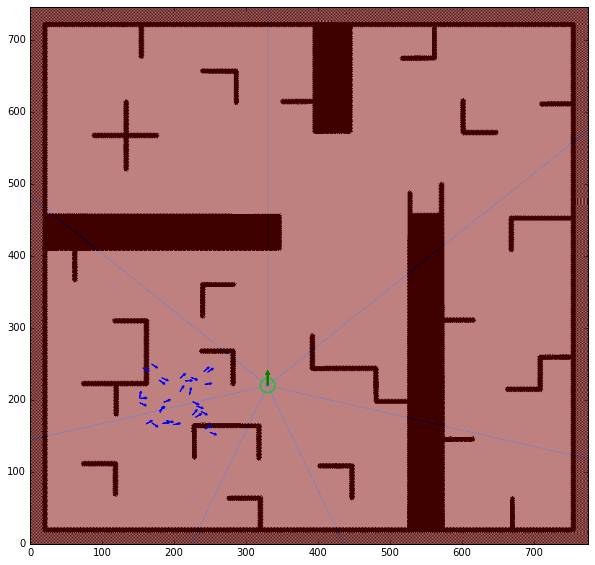

In [13]:
ax = inspercles.nb_draw_map(pil_image, pose=pose, robot=True, particles=particulas)
#ax.imshow(occupancy_image, alpha=0.2)
ax.imshow(lidar_map, alpha=0.5)

## Gerando uma animação

In [14]:
# Coloque nesta lista os deslocamentos do robo

movimentos = [[-10, -10, 0], [-10, 10, 0], [-10,0,0], [-10, 0, 0],
              [0,0,math.pi/12.0], [0, 0, math.pi/12.0], [0, 0, math.pi/12],[0,0,-math.pi/4],
              [-5, 0, 0],[-5,0,0], [-5,0,0], [-10,0,0],[-10,0,0], [-10,0,0],[-10,0,0],[-10,0,0],[-15,0,0],
              [0,0,-math.pi/4],[0, 10, 0], [0,10,0], [0, 10, 0], [0,10,0], [0,0,math.pi/8], [0,10,0], [0,10,0], 
              [0,10,0], [0,10,0], [0,10,0],[0,10,0],
              [0,0,-math.radians(90)],
              [math.cos(math.pi/3)*10, math.sin(math.pi/3),0],[math.cos(math.pi/3)*10, math.sin(math.pi/3),0],[math.cos(math.pi/3)*10, math.sin(math.pi/3),0],
              [math.cos(math.pi/3)*10, math.sin(math.pi/3),0]
              
              ]


In [15]:

plt.ioff() # Desliga o modo interativo, para nao aparecerem muitas imagens no meio

frames = 1

for delta in movimentos:
    for i in range(len(pose)):
        pose[i]+=delta[i]
            
        # Simula a leitura do lidar
        leituras, lidar_map = inspercles.nb_simulate_lidar(pose, angles, np_image)
        
        # Desenha as particulas
        ax = inspercles.nb_draw_map(pil_image, pose=pose, robot=True, particles=particulas)
        #ax.imshow(occupancy_image, alpha=0.2)
        # Desenha o mapa do lidar
        ax.imshow(lidar_map, alpha=0.5)
    
    plt.savefig("anim%04d.png"%frames, bounds="tight")
    
    frames+=1
    plt.close('all')


plt.ion()



('Outside at ', -1.3327392943568377, '  ', 476.2543085639416, '  for angle ', 2.4683942278205517)
('Outside at ', -1.1412542726920214, '  ', 146.70160435479045, '  for angle ', 3.3659921288462069)
('Outside at ', 213.52493042054573, '  ', -1.097760183251609, '  for angle ', 4.2635900298718621)
('Outside at ', 426.47506957945427, '  ', -1.097760183251609, '  for angle ', 5.1611879308975173)
('Outside at ', -1.3327392943568377, '  ', 466.2543085639416, '  for angle ', 2.4683942278205517)
('Outside at ', -1.1412542726920214, '  ', 136.70160435479045, '  for angle ', 3.3659921288462069)
('Outside at ', 218.2108748030156, '  ', -1.3672964099057334, '  for angle ', 4.2635900298718621)
('Outside at ', 421.7891251969844, '  ', -1.3672964099057334, '  for angle ', 5.1611879308975173)
('Outside at ', -1.3327392943568377, '  ', 466.2543085639416, '  for angle ', 2.4683942278205517)
('Outside at ', -1.1412542726920214, '  ', 136.70160435479045, '  for angle ', 3.3659921288462069)
('Outside at ', 2

('Outside at ', -1.045151136380772, '  ', 511.0451511363775, '  for angle ', 2.3561944901923448)
('Outside at ', -1.555162382679725, '  ', 187.14962271128883, '  for angle ', 3.253792391218)
('Outside at ', 150.82040878358453, '  ', -1.5030505181211937, '  for angle ', 4.1513902922436552)
('Outside at ', 367.48346793467556, '  ', -1.4350292903420279, '  for angle ', 5.0489881932693104)
('Outside at ', -1.0451511363807542, '  ', 511.0451511363775, '  for angle ', 8.6393797973719302)
('Outside at ', -1.045151136380772, '  ', 511.0451511363775, '  for angle ', 2.3561944901923448)
('Outside at ', -1.555162382679725, '  ', 187.14962271128883, '  for angle ', 3.253792391218)
('Outside at ', 150.82040878358453, '  ', -1.5030505181211937, '  for angle ', 4.1513902922436552)
('Outside at ', 367.48346793467556, '  ', -1.4350292903420279, '  for angle ', 5.0489881932693104)
('Outside at ', -1.0451511363807542, '  ', 511.0451511363775, '  for angle ', 8.6393797973719302)
('Outside at ', -1.0451511

('Outside at ', -1.2769169774297366, '  ', 416.3992875855027, '  for angle ', 2.4683942278205517)
('Outside at ', -1.2667906171281351, '  ', 163.7912120826353, '  for angle ', 3.3659921288462069)
('Outside at ', 138.52493042054573, '  ', -1.097760183251609, '  for angle ', 4.2635900298718621)
('Outside at ', 351.47506957945427, '  ', -1.097760183251609, '  for angle ', 5.1611879308975173)
('Outside at ', -1.4258402983325456, '  ', 408.5433160820826, '  for angle ', 2.4683942278205517)
('Outside at ', -1.3225259128735565, '  ', 166.0609256089897, '  for angle ', 3.3659921288462069)
('Outside at ', 128.52493042054573, '  ', -1.097760183251609, '  for angle ', 4.2635900298718621)
('Outside at ', 341.47506957945427, '  ', -1.097760183251609, '  for angle ', 5.1611879308975173)
('Outside at ', -1.4258402983325456, '  ', 408.5433160820826, '  for angle ', 2.4683942278205517)
('Outside at ', -1.3225259128735565, '  ', 166.0609256089897, '  for angle ', 3.3659921288462069)
('Outside at ', 128.

('Outside at ', -1.2884098875707057, '  ', 682.2975906897636, '  for angle ', 2.0756951461218276)
('Outside at ', -1.173572166607158, '  ', 335.8798330318817, '  for angle ', 2.9732930471474828)
('Outside at ', -1.1658610949134658, '  ', 111.29064912399144, '  for angle ', 3.8708909481731379)
('Outside at ', 226.92206097617952, '  ', -1.3252127723780895, '  for angle ', 4.7684888491987927)
('Outside at ', 634.2547640326007, '  ', -1.0248082727313796, '  for angle ', 5.6660867502244479)
('Outside at ', -1.2884098875707057, '  ', 682.2975906897636, '  for angle ', 2.0756951461218276)
('Outside at ', -1.173572166607158, '  ', 335.8798330318817, '  for angle ', 2.9732930471474828)
('Outside at ', -1.1658610949134658, '  ', 111.29064912399144, '  for angle ', 3.8708909481731379)
('Outside at ', 226.92206097617952, '  ', -1.3252127723780895, '  for angle ', 4.7684888491987927)
('Outside at ', 634.2547640326007, '  ', -1.0248082727313796, '  for angle ', 5.6660867502244479)
('Outside at ', -1

('Outside at ', -1.088993233756008, '  ', 581.1867789928289, '  for angle ', 2.3000946213782414)
('Outside at ', -1.2356503581280358, '  ', 309.61216063122345, '  for angle ', 3.1976925224038966)
('Outside at ', 0.15176115738359508, '  ', -1.3427009392628135, '  for angle ', 4.0952904234295513)
('Outside at ', 323.3489344524528, '  ', -1.423244748531689, '  for angle ', 4.9928883244552065)
('Outside at ', -1.088993233756008, '  ', 582.0528043966134, '  for angle ', 2.3000946213782414)
('Outside at ', -1.2356503581280358, '  ', 310.47818603500787, '  for angle ', 3.1976925224038966)
('Outside at ', -0.5426443980321727, '  ', -1.4553485782294915, '  for angle ', 4.0952904234295513)
('Outside at ', 323.5150357593077, '  ', -1.1337697379143168, '  for angle ', 4.9928883244552065)
('Outside at ', -1.088993233756008, '  ', 582.0528043966134, '  for angle ', 2.3000946213782414)
('Outside at ', -1.2356503581280358, '  ', 310.47818603500787, '  for angle ', 3.1976925224038966)
('Outside at ', -

Para gerar os gifs é preciso ter o pacote *imagemagick*

O imagemagick pode ser obtido com o seguinte comando:
    sudo apt-get install imagemagick 
    
Agora vamos invocar na linha de comando o seguinte comando:
    convert -delay 10 -loop 1 anim*png animated.gif
    
Este comando criou um arquivo chamado *animated.fig*, que leremos abaixo:
    

In [16]:
!convert -delay 10 -loop 1 anim*png animated.gif

Infelizmente o IPython Notebook 2 nao parece exibir animacoes em Gif por default, mas voce pode abrir o arquivo no diretorio de trabalho e devera'  ve-lo.

<img src="animated.gif">

![](anim.gif)